In [53]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

print("Running on ", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Running on  cpu


In [54]:

class DRIVE(torch.utils.data.Dataset):
    def __init__(self, transform = None, img_size = 128, *args, **kwargs):
    # def __init__(self,  transform = None, *args, **kwargs):
        self.data_path = '/dtu/datasets1/02514/DRIVE/training'
        self.transform = transform if transform else self.default_transform
        self.img_size = (img_size, img_size)

        self.image_paths = sorted(glob.glob(self.data_path + '/images/*.tif'))
        self.mask_paths = sorted(glob.glob(self.data_path + '/1st_manual/*.gif'))


        # call super
        #super().__init__(self.data_path, transform=transform)

        # split train and val and test
        self.train_subset, self.val_subset, self.test_subset = torch.utils.data.random_split(self, [0.2, 0.2, 0.6], generator=torch.Generator().manual_seed(1))
    
    def default_transform(self):
        return transforms.Compose([transforms.Resize((128,128)),
                transforms.ToTensor()])   

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        Y = self.transform(mask)
        X = self.transform(image)
        return X, Y

    @property

    # def default_transform(self):
    #     return transforms.Compose([transforms.Resize((128,128)),
    #             transforms.ToTensor()])
    
    # def train_transform(self):
    #     return transforms.Compose([transforms.Resize((size, size)), 
    #                                 transforms.ToTensor()])
    # test_transform = transforms.Compose([transforms.Resize((size, size)), 
    #                                 transforms.ToTensor()])
    # val_transform = transforms.Compose([transforms.Resize((size, size)),
    #                                 transforms.ToTensor()])


    def get_dataloader(self, batch_size = 4, *args, **kwargs):
        train_loader = DataLoader(dataset=self.train_subset, shuffle=True, batch_size=batch_size, *args, **kwargs)
        val_loader = DataLoader(dataset=self.val_subset, shuffle=False, batch_size=batch_size, *args, **kwargs)
        test_loader = DataLoader(dataset=self.test_subset, shuffle=False, batch_size=batch_size, *args, **kwargs)
        return train_loader, val_loader, test_loader






In [55]:
# modificeret

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
from torch.utils.data import  random_split
import torchvision.transforms as transforms

data_path_drive = '/dtu/datasets1/02514/DRIVE/training'
data_path_lesion = '/dtu/datasets1/02514/PH2_Dataset_images'

class Lesion_Data(torch.utils.data.Dataset):
    def __init__(self, train_transform_size=128, test_transform_size=128, data_path=data_path_lesion):
        'Initialization'
        self.image_paths = sorted(glob.glob(data_path + '/***/**_Dermoscopic_Image/*.bmp'))
        self.mask_paths = sorted(glob.glob(data_path + '/***/**_lesion/*.bmp'))
        self.train_transform = transforms.Compose([transforms.Resize((train_transform_size, train_transform_size)),
                                                            transforms.ToTensor()])
        self.test_transform = transforms.Compose([transforms.Resize((test_transform_size, test_transform_size)),
                                                            transforms.ToTensor()])

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        Y = self.train_transform(mask)
        X = self.train_transform(image)
        return X, Y

    def get_datasets(self):
        train_size = int(0.8 * len(self))
        test_size = len(self) - train_size
        val_size = int(0.2 * train_size)
        train_size = train_size - val_size
        train_dataset, test_dataset, val_dataset = random_split(self, [train_size, test_size, val_size])
        train_dataset.dataset.transform = self.train_transform
        test_dataset.dataset.transform = self.test_transform
        val_dataset.dataset.transform = self.test_transform
        return train_dataset, test_dataset, val_dataset


class DRIVE_data(torch.utils.data.Dataset):
    def __init__(self, train_transform_size=128, test_transform_size=128, data_path=data_path_drive):
        'Initialization'
        self.image_paths = sorted(glob.glob(data_path + '/images/*.tif'))
        self.mask_paths = sorted(glob.glob(data_path + '/1st_manual/*.gif'))



        self.train_transform = transforms.Compose([transforms.Resize((train_transform_size, train_transform_size)),
                                                            transforms.ToTensor()])
        self.test_transform = transforms.Compose([transforms.Resize((test_transform_size, test_transform_size)),
                                                            transforms.ToTensor()])

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        Y = self.train_transform(mask)
        X = self.train_transform(image)
        return X, Y

    def get_datasets(self):
        train_size = int(0.8 * len(self))
        test_size = len(self) - train_size
        val_size = int(0.2 * train_size)
        train_size = train_size - val_size
        train_dataset, test_dataset, val_dataset = random_split(self, [train_size, test_size, val_size])
        train_dataset.dataset.transform = self.train_transform
        test_dataset.dataset.transform = self.test_transform
        val_dataset.dataset.transform = self.test_transform
        return train_dataset, test_dataset, val_dataset


In [56]:
size = 128
batch_size = 32

dataset = Lesion_Data(train_transform_size=size, test_transform_size=size)
trainset, testset, validationset = dataset.get_datasets()

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
validation_loader = DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=3)

In [57]:
from torchvision.utils import save_image
import torch
import torchvision

images, labels = next(iter(train_loader))

img1 = images[0][0]
# img1 = img1.numpy() # TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>
# np.save("file.pdf", img1)

# save_image(img1, 'test.png')
# save_image(img1, 'test.pdf')




# plt.imshow(np.swapaxes(np.swapaxes(images[0], 0, 2), 0, 1))
torch.save(img1, 'tensor.png')

In [58]:
# # import required libraries
# import torch
# import torchvision.transforms as T
# from PIL import Image

# # define a torch tensor
# tensor = img1

# # define a transform to convert a tensor to PIL image
# transform = T.ToPILImage()

# # convert the tensor to PIL image using above transform
# img = transform(tensor)

# # display the PIL image
# img.show()

In [59]:
images, labels = next(iter(train_loader))
images.dtype

torch.float32

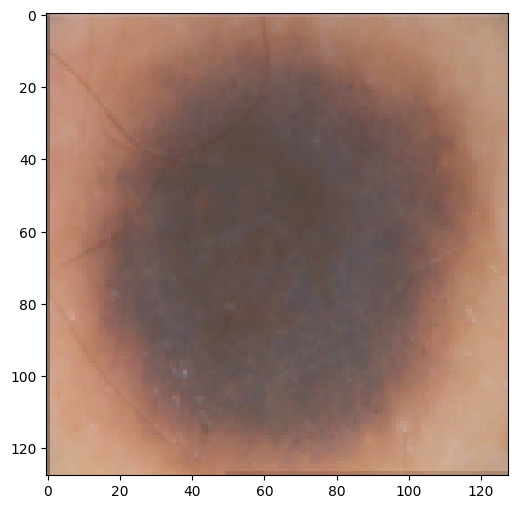

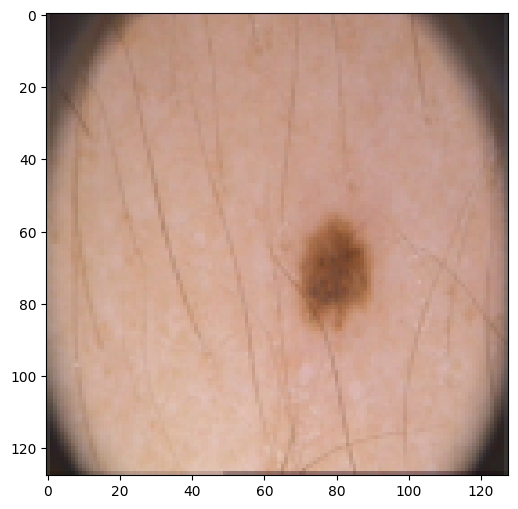

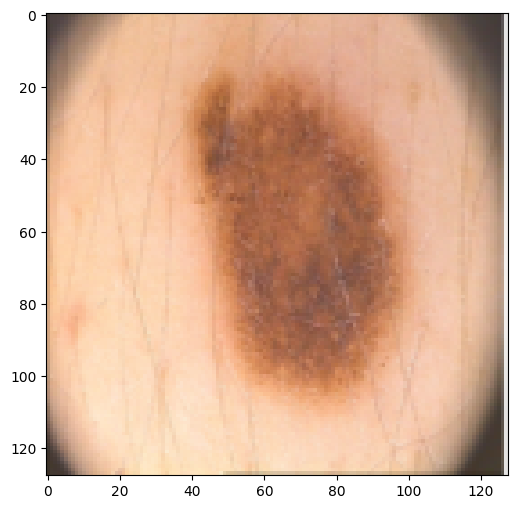

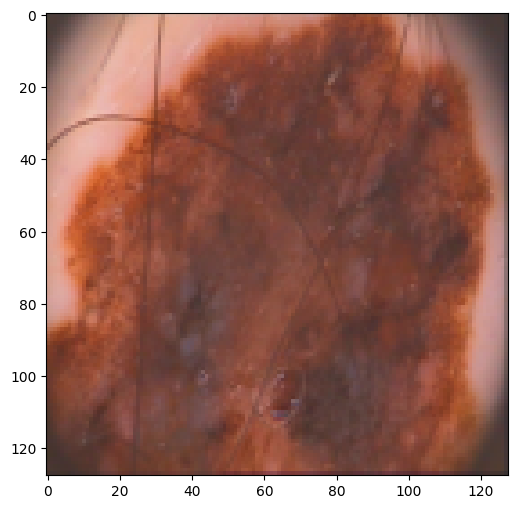

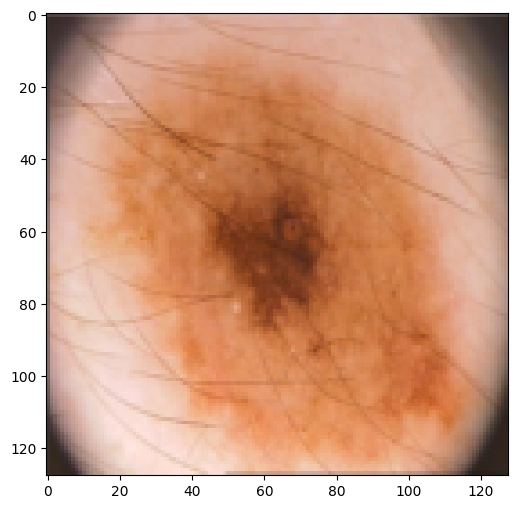

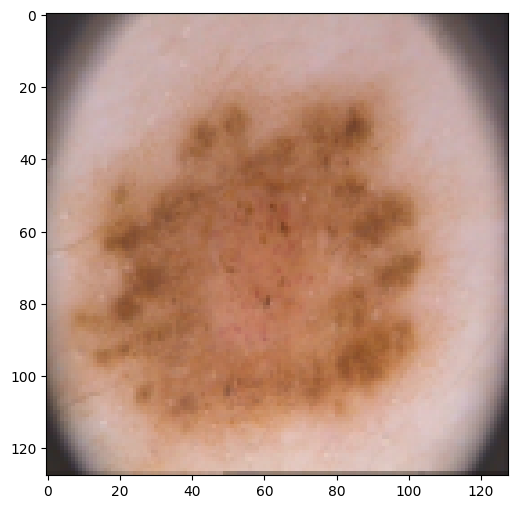

In [60]:
from torchvision.utils import save_image
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(test_loader))



for i in range(6):
    # plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    # plt.subplot(2, 6, i+7)
    # plt.imshow(labels[i].squeeze())
    # plt.imsave(f'test_{i}.png', np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))
    # save_image(images[i], f'test_image{i}.png')
    plt.show()

In [61]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
val_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])

# default_transform = transforms.Compose([transforms.Resize((128,128)),
#                 transforms.ToTensor()])

In [62]:
train_transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [63]:
batch_size = 6
trainset = DRIVE(transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=3)


In [64]:
testset = DRIVE(transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [65]:
valset = DRIVE(transform=val_transform)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=3)

In [66]:
print('Loaded %d training images' % len(trainset))
print('Loaded %d test images' % len(testset))
print('Loaded %d val images' % len(valset))

Loaded 20 training images
Loaded 20 test images
Loaded 20 val images


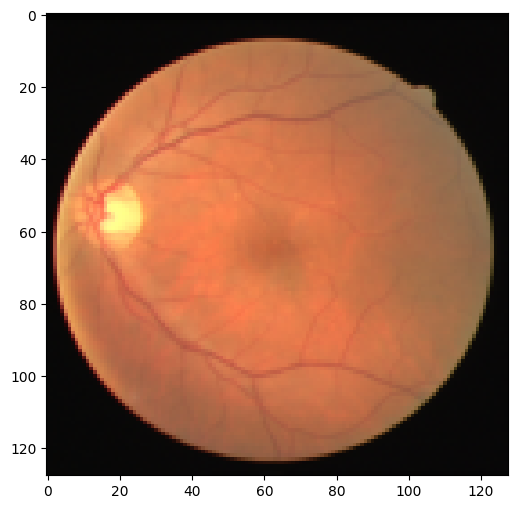

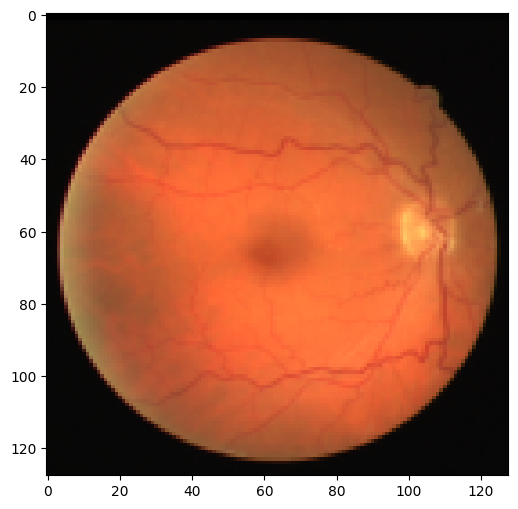

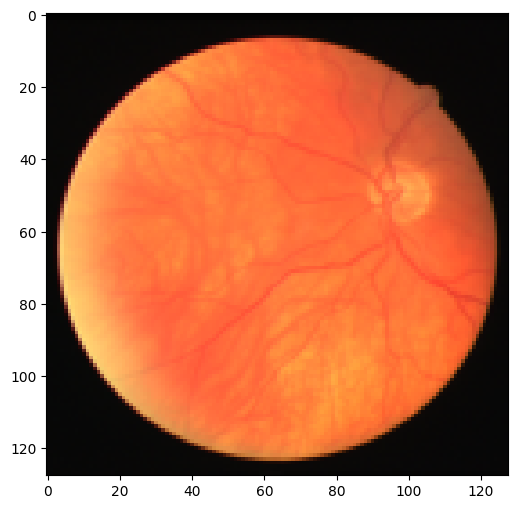

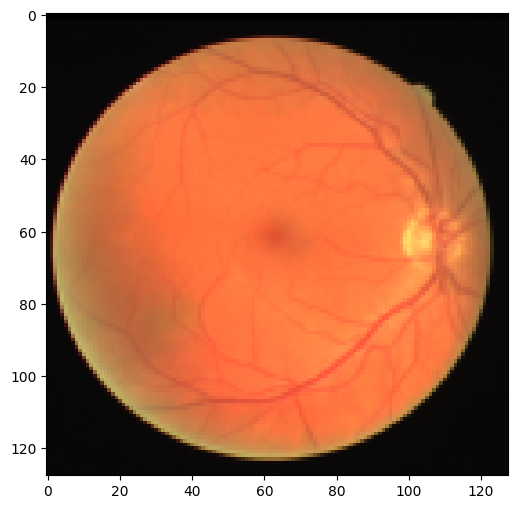

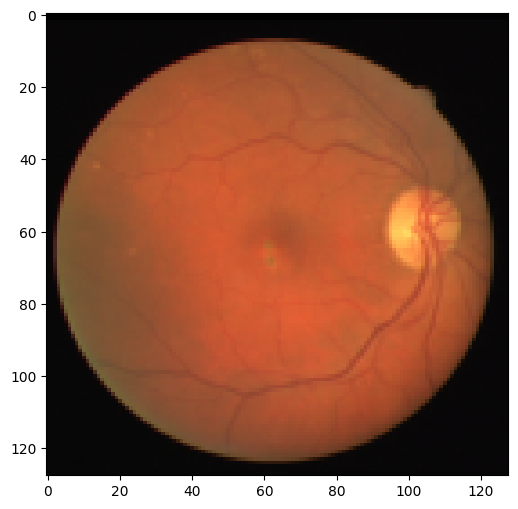

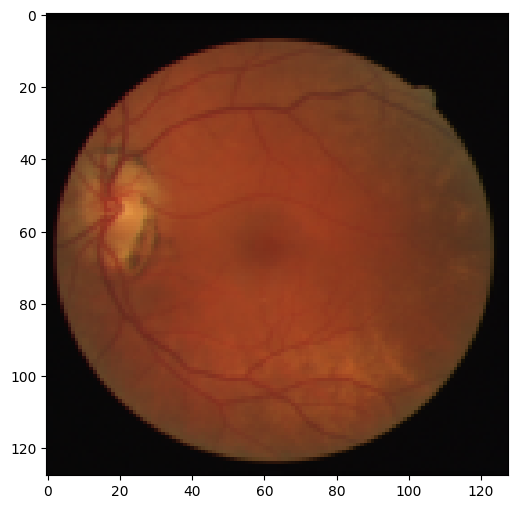

In [70]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(test_loader))

for i in range(6):
    # plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    # plt.subplot(2, 6, i+7)
    # plt.imshow(labels[i].squeeze())
    plt.show()

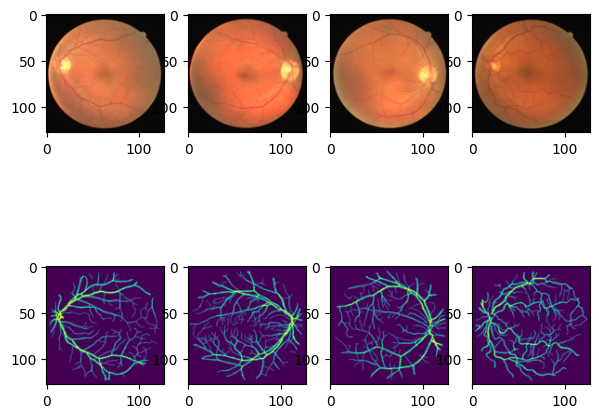

In [ ]:
# save the first 10 images from test set
for i, (images, labels) in enumerate(test_loader):
    if i == 10:
        break
    plt.subplot(2, 10, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[0], 0, 2), 0, 1))
    plt.subplot(2, 10, i+11)
    plt.imshow(labels[0].squeeze())
plt.show()


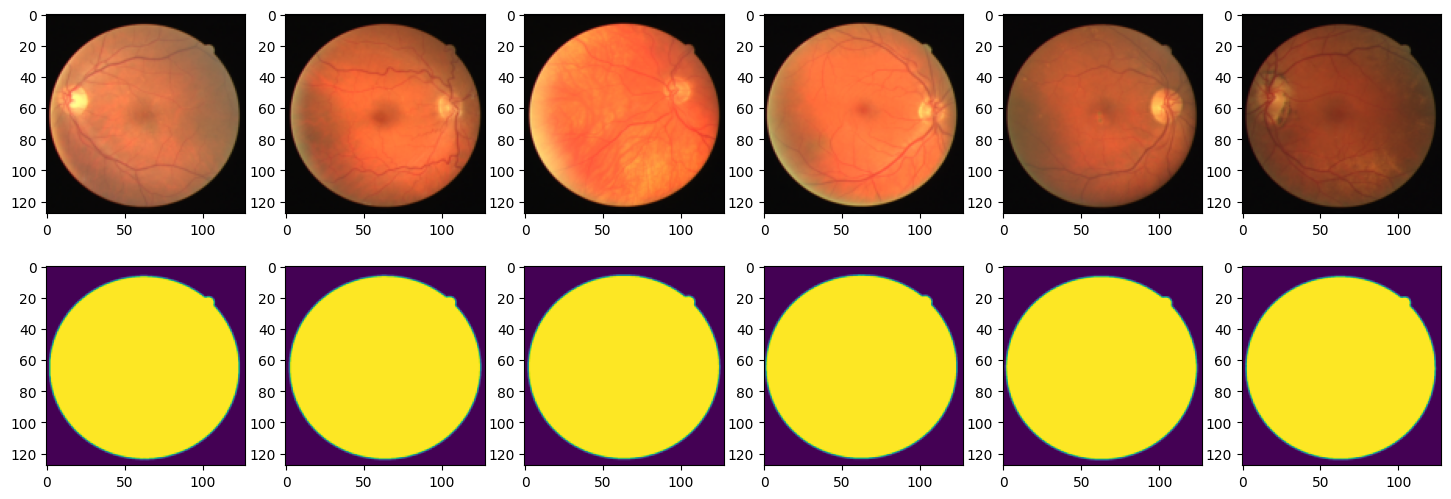

In [ ]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(val_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import random
import glob
import PIL.Image as Image

class DRIVE2(torch.utils.data.Dataset):
    def __init__(self, train = True, transform = None, data_augmentation = True, *args, **kwargs):
        # set datadir
        # self.datadir = 'hotdog/small_data/' + ('train' if train else 'test')
        self.data_path = '/dtu/datasets1/02514/DRIVE/' + ('training' if train else 'test')
        # self.data_path = 'KATRINE_DATA/small_data/' + ('training' if train else 'test')

        # self.data_path = '/dtu/datasets1/02514/DRIVE/training'
        self.transform = transform if transform else self.default_transform
        self.img_size = (128, 128)

        self.train = train
        self.data_augmentation = data_augmentation
        self.image_paths = sorted(glob.glob(self.data_path + '/images/*.tif'))
        self.mask_paths = sorted(glob.glob(self.data_path + '/mask/*.gif'))

        # call super
        # super().__init__(self.datadir, transform=transform, *args, **kwargs)

        # split train and val

    def default_transform(self):
        return transforms.Compose([transforms.Resize((128,128)),
                transforms.ToTensor()])

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path)
        mask = Image.open(mask_path)
        Y = self.transform(mask)
        X = self.transform(image)
        return X, Y

    def get_subsets(self):
        if self.train:
            self.train_subset, self.val_subset, self.test_subset = torch.utils.data.random_split(
        self, [0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(1))





    @property
    # def default_transform(self):
    #     if self.train and self.data_augmentation:

    #         return transforms.Compose([
    #             transforms.Resize(self.img_size),
    #             transforms.ToTensor()])
    #     else:
    #         return transforms.Compose([
    #             transforms.Resize(self.img_size),
    #             transforms.ToTensor()])



    def get_dataloader(self, batch_size = 32, *args, **kwargs):
        # if self.train:
        self.get_subsets()
        train_loader = DataLoader(dataset=self.train_subset, shuffle=True, batch_size=batch_size, *args, **kwargs)
        val_loader = DataLoader(dataset=self.val_subset, shuffle=False, batch_size=batch_size, *args, **kwargs)
        test_loader = DataLoader(dataset=self.test_subset, shuffle=False, batch_size=batch_size, *args, **kwargs)

        return train_loader, val_loader, test_loader
        # else:
        #     return DataLoader(self, batch_size=batch_size, shuffle=False, *args, **kwargs)
        # DataLoader(testset, batch_size=batch_size, shuffle=False)


    def transform_label(self, label):
        return self.classes[label]


# if __name__ == "__main__":
#     dataset = DRIVE2()
#     train_loader, val_loader, test_loader = dataset.get_dataloader(batch_size=32, shuffle=True)
#     images, labels = next(iter(train_loader))
#     plt.figure(figsize=(20,10))

#     for i in range(21):
#         plt.subplot(5,7,i+1)
#         plt.imshow(images[i].numpy().transpose(1,2,0))
#         plt.title(dataset.transform_label(labels[i].item()))
#         plt.axis('off')

#     plt.savefig('DRIVE2_overview.png')


In [ ]:
train_subset, val_subset, test_subset = torch.utils.data.random_split(DRIVE2(), [0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(1))


def get_dataloader( batch_size = 32, *args, **kwargs):
    # if self.train:
    
    train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=batch_size, *args, **kwargs)
    val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=batch_size, *args, **kwargs)
    test_loader = DataLoader(dataset=test_subset, shuffle=False, batch_size=batch_size, *args, **kwargs)

    return train_loader, val_loader, test_loader


In [ ]:
train_loader, val_loader, test_loader = get_dataloader(batch_size=32)

In [ ]:
images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

TypeError: DRIVE2.default_transform() takes 1 positional argument but 2 were given